<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/basic-transformers/Basic-Transformer/basic_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Transformer

[Link](https://www.tensorflow.org/tutorials/text/transformer) to original tutorial.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Apr  1 08:09:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 10.9MB/s 


In [4]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
import os
import sys
import numpy as np

In [5]:
os.chdir('/content/drive/MyDrive/Basic-Transformer')

In [6]:
## Suppress Tensorflow warnings

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
# Dataset Download
# Portugese to English word translation
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [8]:
# Snippet of what train_example looks like
for pt_examples, en_examples in train_examples.batch(1).take(1):

  print("Portuguese Example:")
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print("\nEnglish Example:")
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

Portuguese Example:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .

English Example:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


In [9]:
# Tokennization and detokenization

model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(f"{model_name}.zip",
                        f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
                        cache_dir='.', cache_subdir='.', extract=True)

'././ted_hrlr_translate_pt_en_converter.zip'

In [10]:
# Loading the tokenizers from the downloaded model
tokenizers = tf.saved_model.load(model_name)

In [11]:
# Let's look at the methods inherited by the Tokenizers

# This is for the English tokenizer
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [12]:
# This is for the Portuguese tokenizer
[item for item in dir(tokenizers.pt) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

As we can see both the tokenizers inherit same methods. It'll be easy for us to perform similar operations on each texts in parallel.

In [13]:
print("Let's tokenize this string.\n")

print("Non Tokenized String: ")
for en in en_examples.numpy():
  print(en.decode('utf-8'))

print()

# Encoding the string
encoded = tokenizers.en.tokenize(en_examples)

print("Tokenized string: ")
for row in encoded.to_list():
  print(row)
print()

print('Now, lets try to detokenize the string and see if we get back the original string back.\n')

# Decoding the string
decoded = tokenizers.en.detokenize(encoded)

print('Detokenized String:')
for row in decoded.numpy():
  print(row.decode('utf-8'))

Let's tokenize this string.

Non Tokenized String: 
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

Tokenized string: 
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]

Now, lets try to detokenize the string and see if we get back the original string back.

Detokenized String:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


In [14]:
## We can use the lookup method to get the token-text from token-IDs

tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]']]>

We can see that the word `searchability` is tokenized in a sub-word manner. It is comprised of two tokens, namely `search` and `##ability`. Similarly it is the same for `serendipity`.


## Setup Input pipeline


In [15]:
def tokenize_pairs(pt, en):
  pt = tokenizers.pt.tokenize(pt)
  pt = pt.to_tensor()

  en = tokenizers.en.tokenize(en)
  en = en.to_tensor()

  return pt, en

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds.cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
  )

In [18]:
# Preparing batches for Training and Validation
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

As we know that Transformers have a disadvantage that if the training set like text, doesn't have any positional encoding the transformers will just treat them as Bag of Words.

### Positional Encoding

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$$

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [19]:
# Creating Positional Encoding for the train examples.
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  ## handling PE for Even indices
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # handling PE for Odd indices
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [29]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
pos_encoding = pos_encoding[0]
pos_encoding.shape

TensorShape([2048, 512])

In [30]:
# Inverting the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2)) ## Here d//2, will provide the output in integer format
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

In [32]:
import matplotlib.pyplot as plt

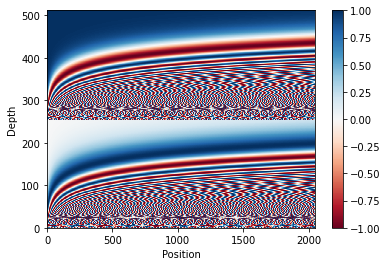

In [33]:
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Since we added padding, we don't want our model to treat padding as an input. To overcome this we'll introduce Masking. We'll create a Mask Tensor, which will have value `1.`, wherever there's padding added in our input sequence.

In [38]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [39]:
# Trying to see the working of the above function

x = tf.constant([[1,2,3,4,0],[2,1,0,1,0], [0,0,0,0,1]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1.]]],


       [[[0., 0., 1., 0., 1.]]],


       [[[1., 1., 1., 1., 0.]]]], dtype=float32)>


The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [53]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)

  ## Info regarding 
  ## tf.linalg.band_part(input, 0, -1) ==> Upper triangular part.
  ## tf.linalg.band_part(input, -1, 0) ==> Lower triangular part.
  ## tf.linalg.band_part(input, 0, 0) ==> Diagonal.

  ## Later,
  ## Inversing 1->0 and 0->1.
  return mask # dims: (size, size)

In [52]:
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

As we can see here, that we are choosing the lower triangular region in this example, which helps in the look ahead stage, which words to choose and which not to choose.

## Scaled Dot Product Attention

The Attention Function is comprised of three vectors, namely, Query, Key and Value vectors. For more details, go through this [blog](https://towardsdatascience.com/transformers-89034557de14). 

The Formula to calculate Attention is:

$$Attention(Q,K,V) = softmax_k\left( \dfrac{QK^T}{\sqrt{d_k}} \right ) V$$

$d_k$ is used to scale the Dot Product between `Q` and `K`, in order to overcome vanishing gradients. `Q` and `K` will follow mean `0` and variance `1`, so their product will follow mean `1` and std $d_k$, So $\sqrt{d_k}$ is used for scaling.

<div align="center">
<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" />
</div>

In [54]:
def scaled_dot_product_attention(q, k, v, mask):

  ## Transpose_b is used to invert the k matrix
  matmul_q_k = tf.matmul(q, k, transpose_b=True) ## (..., seq_len_q, seq_len_k)

  dk = tf.cast(tf.shape(k)[-1], tf.float32) ## seq_len_k

  scaled_attention_logits = matmul_q_k / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9) # -1e9 is close to negative infinity
  
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [56]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
  print("Attention weights are:")
  print(temp_attn)
  print("Output is:")
  print(temp_out)

In [58]:
np.set_printoptions(suppress=True)

In [74]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype=tf.float32)

print('This `query` aligns with the second `key`,so the second `value` is returned.\n')
temp_q = tf.constant([[0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

print()

print("This query aligns with a repeated key (third and fourth), so all associated values get averaged.\n")
temp_q = tf.constant([[0,0,10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


print()

print("This query aligns equally with the first and second key, so their values get averaged.\n")
temp_q = tf.constant([[10,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


print()

print("Pass all the queries together.\n")
temp_q = tf.constant([[10,10,0],
                      [10,0,0],
                      [0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


This `query` aligns with the second `key`,so the second `value` is returned.

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

This query aligns with a repeated key (third and fourth), so all associated values get averaged.

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

This query aligns equally with the first and second key, so their values get averaged.

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)

Pass all the queries together.

Attention weights are:
tf.Tensor(
[[0.5 0.5 0.  0. ]
 [1.  0.  0.  0. ]
 [0.  1.  0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 5.5  0. ]
 [ 1.   0. ]
 [10.   0. ]], shape=(3, 2), dtype=float32)


## Multi-Head Attention

- Linear Layers and spilt into Heads.
- Scaled dot-product attention
- Concatenation of heads
- Final Linear Layer

<div align="center">

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png">
</div>

In [120]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    self.depth = d_model // self.num_heads # Value converts to Integer

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """
    Should return a tensor of (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
  
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights


In [121]:
## Lets try out the MHA class

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha.call(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network


In [123]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
                              tf.keras.layers.Dense(dff, activation='relu'),
                              tf.keras.layers.Dense(d_model)
  ])

In [125]:
## Testing PWFFN

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

<div align="center">

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" >

</div>